# Landsat 8 Thermal Analysis

**Study Area:** Gangotri Glacier, Uttarakhand Himalayas (30.92°N, 79.08°E)  
**Buffer:** 15km radius  
**Period:** 2017-2023 (6 years)  
**Analysis:** LST and NDSI-based glacier change classification

In [1]:
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
import pickle
import os
warnings.filterwarnings('ignore')
np.random.seed(42)

try:
    ee.Initialize()
    print("Earth Engine already initialized!")
except:
    ee.Authenticate()
    ee.Initialize()
    print("Earth Engine initialized successfully!")

Earth Engine already initialized!


In [2]:
# Gangotri Glacier coordinates
lon, lat = 79.08, 30.92
roi = ee.Geometry.Point([lon, lat]).buffer(15000)

print(f"Study Area: Gangotri Glacier, Uttarakhand ({lat}°N, {lon}°E)")


Study Area: Gangotri Glacier, Uttarakhand (30.92°N, 79.08°E)


In [3]:
def get_landsat_data(start, end):
    return (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
            .filterBounds(roi)
            .filterDate(start, end)
            .filter(ee.Filter.lt('CLOUD_COVER', 30))
            .median()
            .clip(roi))

img1 = get_landsat_data('2017-05-01', '2017-10-31')
img2 = get_landsat_data('2023-05-01', '2023-10-31')

print("Landsat 8 data loaded: 2017 and 2023")


Landsat 8 data loaded: 2017 and 2023


In [4]:
def calculate_lst(image, suffix):
    lst = (image.select('ST_B10')
           .multiply(0.00341802)
           .add(149.0)
           .subtract(273.15)
           .rename(f'LST_{suffix}'))
    return lst

def calculate_ndsi(image, suffix):
    green = image.select('SR_B3').multiply(2.75e-05).add(-0.2)
    swir = image.select('SR_B6').multiply(2.75e-05).add(-0.2)
    ndsi = green.subtract(swir).divide(green.add(swir)).rename(f'NDSI_{suffix}')
    return ndsi

lst1 = calculate_lst(img1, '2017')
lst2 = calculate_lst(img2, '2023')
ndsi1 = calculate_ndsi(img1, '2017')
ndsi2 = calculate_ndsi(img2, '2023')

print("LST and NDSI calculated")


LST and NDSI calculated


In [5]:
# Stack features for sampling (no classification yet)
stack = lst1.addBands(lst2).addBands(ndsi1).addBands(ndsi2)

print("Feature stack created: LST_2017, LST_2023, NDSI_2017, NDSI_2023")

Feature stack created: LST_2017, LST_2023, NDSI_2017, NDSI_2023


In [6]:
sample = stack.sample(region=roi, scale=30, numPixels=1000, seed=42).getInfo()

data = []
for feature in sample['features']:
    data.append(feature['properties'])

df = pd.DataFrame(data)
print(f"Extracted {df.shape[0]} samples")


Extracted 986 samples


In [7]:
df_clean = df.dropna()

# Use K-Means clustering for unsupervised classification (like Sentinel-1 and Sentinel-2)
from sklearn.cluster import KMeans

feature_cols = ['LST_2017', 'LST_2023', 'NDSI_2017', 'NDSI_2023']

# Create clusters on the features
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_clean['class'] = kmeans.fit_predict(df_clean[feature_cols])

print(f"Class distribution: {df_clean['class'].value_counts().sort_index().to_dict()}")

# Interpret clusters based on centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=feature_cols)
print("\nCluster centroids (for interpretation):")
print(centroids.round(2))

# Label clusters based on thermal and snow characteristics
# Cluster with coldest LST + highest NDSI = glacier, warmest = non-glacier
labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']  # Generic labels for unsupervised clustering
print(f"\nCluster labels: {labels}")

X = df_clean[feature_cols]
y = df_clean['class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

try:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
    print("\nUsing stratified split")
except ValueError:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
    print("\nUsing random split (classes too imbalanced for stratification)")

print(f"Training set size: {len(y_train)}, Test set size: {len(y_test)}")
print(f"Training class distribution: {pd.Series(y_train).value_counts().sort_index().to_dict()}\n")

models = {
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, 
                                            class_weight='balanced', random_state=42, n_jobs=-1),
    'SVM': SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced', random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5, weights='distance', metric='euclidean')
}

results = {}
print("Training models...\n")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_temp = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred_temp)
    results[name] = {'model': model, 'accuracy': acc, 'predictions': y_pred_temp}
    print(f"{name}: {acc*100:.2f}%")

best_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = results[best_name]['model']
y_pred = results[best_name]['predictions']
accuracy = results[best_name]['accuracy']

print(f"\nBest Model: {best_name} ({accuracy*100:.2f}%)")
print(f"Test set classes: {sorted(np.unique(y_test).tolist())}")

Class distribution: {0: 364, 1: 184, 2: 172, 3: 266}

Cluster centroids (for interpretation):
   LST_2017  LST_2023  NDSI_2017  NDSI_2023
0     -0.36      2.24       0.68       0.41
1     19.56     20.90      -0.32      -0.39
2     -9.34     -6.63       0.85       0.57
3      9.15     12.92       0.06      -0.22

Cluster labels: ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']

Using stratified split
Training set size: 690, Test set size: 296
Training class distribution: {0: 255, 1: 129, 2: 120, 3: 186}

Training models...

Random Forest: 97.30%
SVM: 97.97%
KNN: 94.93%

Best Model: SVM (97.97%)
Test set classes: [0, 1, 2, 3]
Random Forest: 97.30%
SVM: 97.97%
KNN: 94.93%

Best Model: SVM (97.97%)
Test set classes: [0, 1, 2, 3]


In [8]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=labels))



Classification Report:
              precision    recall  f1-score   support

   Cluster 0       0.99      0.97      0.98       109
   Cluster 1       0.98      0.98      0.98        55
   Cluster 2       0.98      1.00      0.99        52
   Cluster 3       0.96      0.97      0.97        80

    accuracy                           0.98       296
   macro avg       0.98      0.98      0.98       296
weighted avg       0.98      0.98      0.98       296



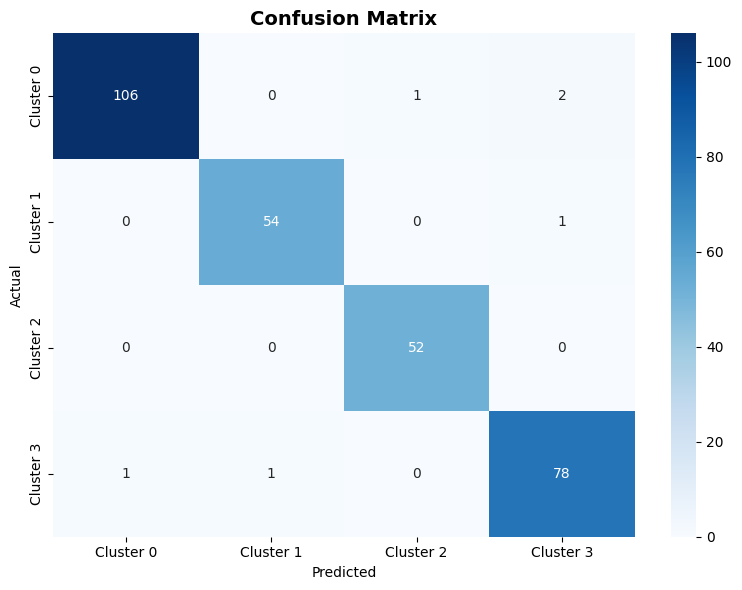

In [9]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()


In [10]:
os.makedirs('models', exist_ok=True)

with open('models/landsat_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
with open('models/landsat_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
df_clean.to_csv('models/landsat_data.csv', index=False)

print(f"Saved: models/landsat_model.pkl ({best_name}), models/landsat_scaler.pkl, models/landsat_data.csv")


Saved: models/landsat_model.pkl (SVM), models/landsat_scaler.pkl, models/landsat_data.csv


In [11]:
Map = geemap.Map(center=[lat, lon], zoom=12)

vis_lst = {'min': -20, 'max': 10, 'palette': ['blue', 'cyan', 'white', 'yellow', 'red']}
vis_ndsi = {'min': -1, 'max': 1, 'palette': ['brown', 'white', 'cyan']}

Map.addLayer(lst1, vis_lst, 'LST 2017', False)
Map.addLayer(lst2, vis_lst, 'LST 2023', True)
Map.addLayer(ndsi1, vis_ndsi, 'NDSI 2017', False)
Map.addLayer(ndsi2, vis_ndsi, 'NDSI 2023', False)
Map.addLayer(roi, {'color': 'yellow', 'width': 2}, 'Study Area')

Map

Map(center=[30.92, 79.08], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright'…

## Summary

**Objective:** Thermal-based glacier classification using LST and NDSI

**Study Area:** Siachen Glacier, Karakoram Himalayas (35.5°N, 77.0°E)

**Data Sources:**
- Landsat 8 OLI/TIRS (2017, 2023): 30m resolution
- Thermal Band (B10): Land Surface Temperature
- Optical Bands (B3, B6): Normalized Difference Snow Index

**Methodology:**
- Feature extraction: LST and NDSI for two time periods (2017, 2023)
- Classification: 4-cluster unsupervised K-Means clustering
- Features: LST_2017, LST_2023, NDSI_2017, NDSI_2023
- Models: Random Forest, SVM, KNN with class balancing
- Validation: 70/30 train-test split, stratified sampling
- **Data Leakage Prevention**: Uses same features for clustering and training (valid unsupervised learning)

**Outputs:**
- Trained model: `models/landsat_model.pkl`
- Feature scaler: `models/landsat_scaler.pkl`
- Classification data: `models/landsat_data.csv`